<h1>Logistic Regression Cross Entropy</h1> 


In [14]:
# GPU Monitoring and Performance Check
import torch
import subprocess
import numpy as np
from datetime import datetime

print("="*80)
print("GPU PERFORMANCE MONITORING")
print("="*80)

# Basic PyTorch and CUDA info
print(f"\nPyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"CuDNN Version: {torch.backends.cudnn.version()}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    
    for i in range(torch.cuda.device_count()):
        print(f"\nGPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory Allocated: {torch.cuda.memory_allocated(i)/1024**2:.2f} MB")
        print(f"  Memory Cached: {torch.cuda.memory_reserved(i)/1024**2:.2f} MB")
        print(f"  Device Capability: {torch.cuda.get_device_capability(i)}")
    
    # Set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"\nUsing device: {device}")
    
    # Run a simple performance test
    print("\nRunning performance test...")
    x = torch.randn(10000, 10000, device=device)
    y = torch.randn(10000, 10000, device=device)
    
    # Warm-up
    _ = torch.mm(x, y)
    torch.cuda.synchronize()
    
    # Time the operation
    start_time = datetime.now()
    _ = torch.mm(x, y)
    torch.cuda.synchronize()
    elapsed = (datetime.now() - start_time).total_seconds()
    
    print(f"10000x10000 matrix multiplication took: {elapsed*1000:.2f} ms")
    
    # Memory usage
    print("\nMemory Usage:")
    print(f"Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
    print(f"Cached: {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")
    
    # GPU utilization
    try:
        gpu_info = subprocess.check_output(['nvidia-smi', '--query-gpu=utilization.gpu,memory.used,memory.total', '--format=csv,nounits,noheader'])
        gpu_info = gpu_info.decode('utf-8').strip().split(',')
        print(f"\nGPU Utilization: {gpu_info[0].strip()}%")
        print(f"GPU Memory Used: {int(gpu_info[1])} / {int(gpu_info[2])} MB")
    except:
        print("\nCouldn't get GPU utilization (nvidia-smi not found)")
else:
    print("\nCUDA is not available. Running on CPU.")
    device = torch.device("cpu")
    print(f"Using device: {device}")

print("\n" + "="*80)

GPU PERFORMANCE MONITORING

PyTorch Version: 2.7.0+cpu
CUDA Available: False

CUDA is not available. Running on CPU.
Using device: cpu



<h2>Objective</h2><ul><li> How Cross-Entropy using random initialization influence the accuracy of the model.</li></ul> 


<h2>Table of Contents</h2>
<p>In this lab, you will review how to make a prediction in several different ways by using PyTorch.</p>
 
<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3">
        1. <a href="#Get-Some-Data">Get Some Data</a><br>
        2. <a href="#Create-the-Model-and-Total-Loss-Function">Create the Model and Total Loss Function</a><br>
        3. <a href="#Train-the-Model-via-Batch-Gradient-Descent">Train the Model via Batch Gradient Descent</a>
    
<p>Estimated Time Needed: <strong>15 min</strong></p>
</font>
</div>


<h2>Preparation</h2>


We'll need the following libraries:


In [15]:
# Import the libraries we need for this lab

import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

The class <code>plot_error_surfaces</code> is just to help you visualize the data space and the parameter space during training and has nothing to do with Pytorch. 


In [16]:
# Create class for plotting and the function for plotting

class plot_error_surfaces(object):
    
    # Construstor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)    
        Z = np.zeros((30, 30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                yhat= 1 / (1 + np.exp(-1*(w2*self.x+b2)))
                Z[count1,count2]=-1*np.mean(self.y*np.log(yhat+1e-16) +(1-self.y)*np.log(1-yhat+1e-16))
                count2 += 1   
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure()
            plt.figure(figsize=(7.5, 5))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
            
     # Setter
    def set_para_loss(self, model, loss):
        self.n = self.n + 1
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
        self.LOSS.append(loss)
    
    # Plot diagram
    def final_plot(self): 
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c='r', marker='x', s=200, alpha=1)
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
        
    # Plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x, self.y, 'ro', label="training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label="estimated line")
        plt.plot(self.x, 1 / (1 + np.exp(-1 * (self.W[-1] * self.x + self.B[-1]))), label='sigmoid')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1, 2))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.show()
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.title('Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')
        
# Plot the diagram

def PlotStuff(X, Y, model, epoch, leg=True):
    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))
    plt.plot(X.numpy(), Y.numpy(), 'r')
    if leg == True:
        plt.legend()
    else:
        pass

Set the random seed:


In [17]:
# Set random seed

torch.manual_seed(0)

<!--Empty Space for separating topics-->


<h2 id="Get-Some-Data">Get Some Data</h2>


In [18]:
# Create the data class

class Data(Dataset):
    
    # Constructor
    def __init__(self):
        self.x = torch.arange(-1, 1, 0.1).view(-1, 1)
        self.y = torch.zeros(self.x.shape[0], 1)
        self.y[self.x[:, 0] > 0.2] = 1
        self.len = self.x.shape[0]
    
    # Getter
    def __getitem__(self, index):      
        return self.x[index], self.y[index]
    
    # Get length
    def __len__(self):
        return self.len

Make <code>Data</code> object


In [19]:
# Create Data object

data_set = Data()

<!--Empty Space for separating topics-->


<h2 id="Create-the-Model-and-Total-Loss-Function">Create the Model and Total Loss Function</h2>


Create a custom module for logistic regression:


In [20]:
# Create logistic_regression class

class logistic_regression(nn.Module):
    
    # Constructor
    def __init__(self, n_inputs):
        super(logistic_regression, self).__init__()
        self.linear = nn.Linear(n_inputs, 1)
        
    # Prediction
    def forward(self, x):
        yhat = torch.sigmoid(self.linear(x))
        return yhat

Create a logistic regression object or model: 


In [21]:
# Create the logistic_regression result

model = logistic_regression(1)

Replace the random initialized variable values. Theses random initialized variable values did convergence for the RMS Loss but will converge for the Cross-Entropy Loss.


In [22]:
# Set the weight and bias

model.state_dict() ['linear.weight'].data[0] = torch.tensor([[-5]])
model.state_dict() ['linear.bias'].data[0] = torch.tensor([[-10]])
print("The parameters: ", model.state_dict())

The parameters:  OrderedDict({'linear.weight': tensor([[-5.]]), 'linear.bias': tensor([-10.])})


Create a <code> plot_error_surfaces</code> object to visualize the data space and the parameter space during training:


<Figure size 640x480 with 0 Axes>

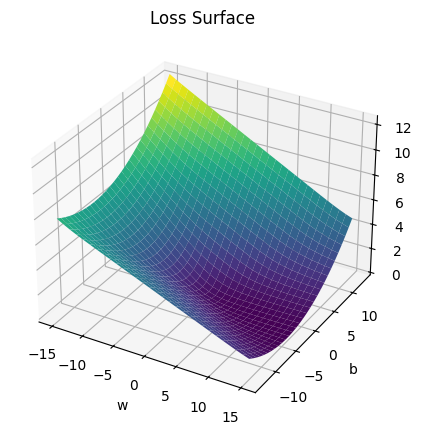

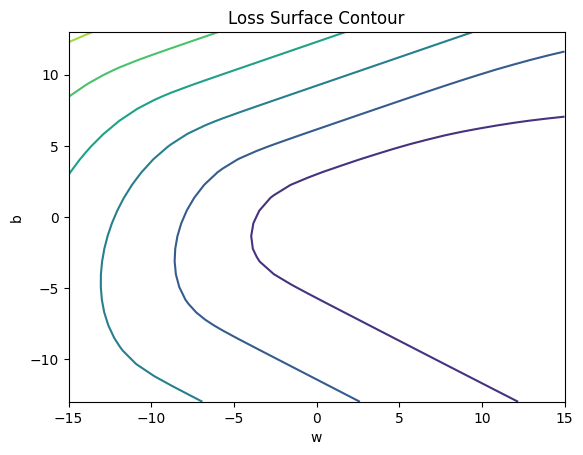

In [23]:
# Create the plot_error_surfaces object

get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

Define the cost or criterion function: 


In [24]:
# Create dataloader, criterion function and optimizer

def criterion(yhat,y):
    out = -1 * torch.mean(y * torch.log(yhat) + (1 - y) * torch.log(1 - yhat))
    return out

# Build in criterion
# criterion = nn.BCELoss()

trainloader = DataLoader(dataset = data_set, batch_size = 3)
learning_rate = 2
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

<!--Empty Space for separating topics-->


<h2 id="Train-the-Model-via-Batch-Gradient-Descent">Train the Model via Batch Gradient Descent</h2>


Train the model


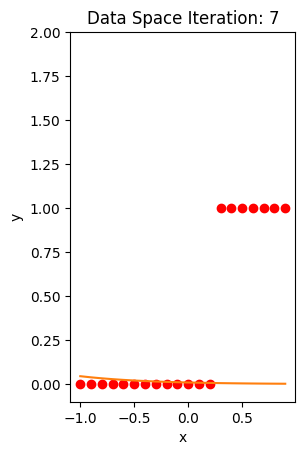

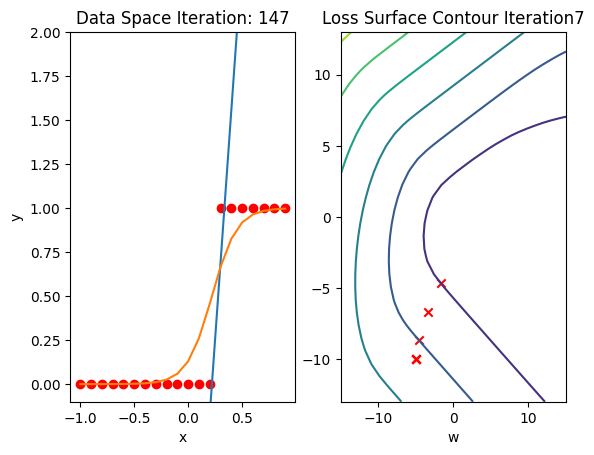

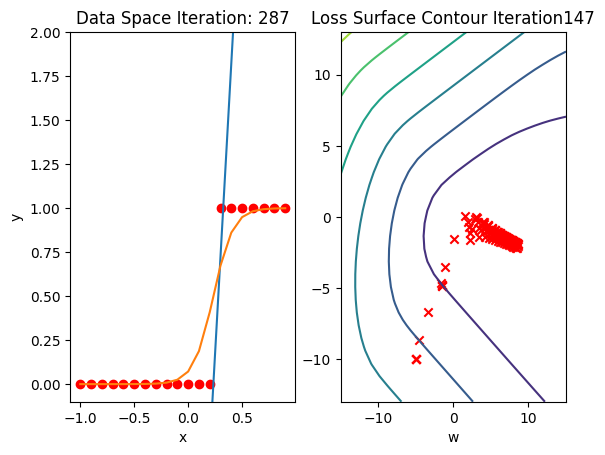

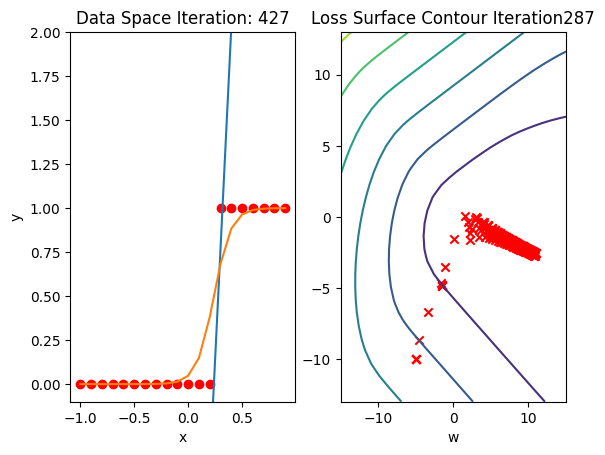

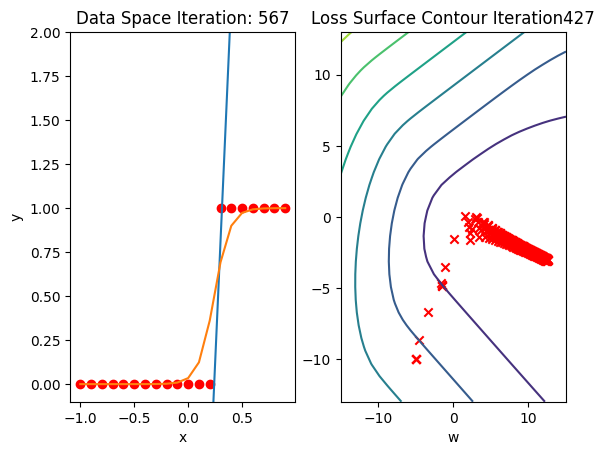

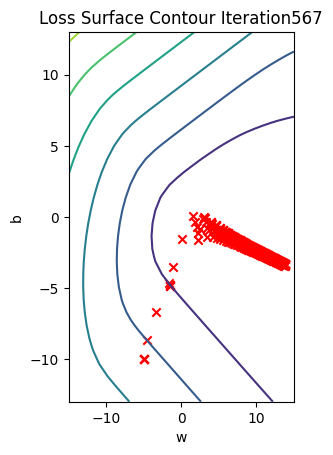

In [25]:
# Train the Model

def train_model(epochs):
    for epoch in range(epochs):
        for x, y in trainloader:
            yhat = model(x)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            get_surface.set_para_loss(model, loss.tolist())
        if epoch % 20 == 0:
            get_surface.plot_ps()
            
train_model(100)

Get the actual class of each sample and calculate the accuracy on the test data:


In [26]:
# Make the Prediction

yhat = model(data_set.x)
label = yhat > 0.5
print("The accuracy: ", torch.mean((label == data_set.y.type(torch.ByteTensor)).type(torch.float)))

The accuracy:  tensor(1.)


The accuracy is perfect.


In [27]:
def track_training_performance(model, train_loader, criterion, optimizer, num_epochs=1):
    """Track GPU memory usage and training performance"""
    if not torch.cuda.is_available():
        print("CUDA is not available. Cannot track GPU performance.")
        return
    
    print("\n" + "="*80)
    print("TRAINING PERFORMANCE METRICS")
    print("="*80)
    
    model = model.to(device)
    model.train()
    
    # Clear cache before starting
    torch.cuda.empty_cache()
    
    # Track metrics
    start_mem = torch.cuda.memory_allocated()/1024**2
    start_time = datetime.now()
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)
            loss = criterion(output, target)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            # Print batch stats
            if (batch_idx + 1) % 10 == 0:
                current_mem = torch.cuda.memory_allocated()/1024**2
                print(f"Batch {batch_idx + 1}: "
                      f"Loss: {loss.item():.6f} | "
                      f"Memory: {current_mem:.2f}MB | "
                      f"Peak Memory: {torch.cuda.max_memory_allocated()/1024**2:.2f}MB")
    
    # Print summary
    total_time = (datetime.now() - start_time).total_seconds()
    peak_mem = torch.cuda.max_memory_allocated()/1024**2
    print("\n" + "="*80)
    print("TRAINING SUMMARY")
    print("="*80)
    print(f"Total Training Time: {total_time:.2f} seconds")
    print(f"Peak GPU Memory Usage: {peak_mem:.2f} MB")
    print(f"Memory Increase: {peak_mem - start_mem:.2f} MB")
    print("="*80)
    
    # Reset peak memory
    torch.cuda.reset_peak_memory_stats()


<!--Empty Space for separating topics-->
